In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.transpiler import CouplingMap

from gate_level.spillover_noise_use_case.generic_spillover.generic_spillover_noise import (
    numpy_to_hashable,
)
from generic_spillover_noise import (
    circuit_context,
    noisy_backend,
    SpilloverNoiseAerPass,
)
from rl_qoc import (
    ContextAwareQuantumEnvironment,
    QiskitConfig,
    QEnvConfig,
    ExecutionConfig,
)
import matplotlib.pyplot as plt

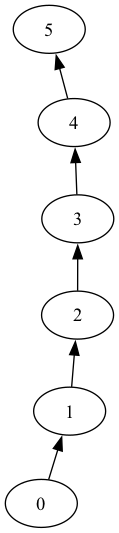

In [2]:
# Define the number of qubits
num_qubits = 6
cm = CouplingMap.from_line(num_qubits, False)
cm.draw()

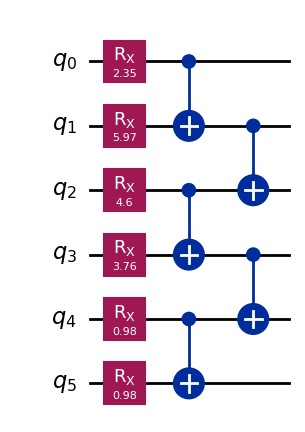

In [3]:
# Define parameters for U(phi) gates
# phi_rotation_values = np.pi * np.array([0.25, 0.5, 0.75, 1])
# phi_arr = np.random.choice(phi_rotation_values, size=num_qubits)
n_layers = 1
seed = 42
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, size=num_qubits * n_layers)
from qiskit.circuit.library import n_local

qc = n_local(
    num_qubits,
    "rx",
    ["cx", "cx"],
    entanglement=[[(0, 1), (2, 3), (4, 5)], [(1, 2), (3, 4)]],
    reps=n_layers,
    skip_unentangled_qubits=True,
    skip_final_rotation_layer=True,
)
qc = qc.assign_parameters(rotation_angles, inplace=False)
qc.draw("mpl")

In [4]:
print(qc.data)

[CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[2.353304971691044]), qubits=(<qiskit.circuit.quantumregister.Qubit object at 0x378b3adc0>,), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[5.9735141613602165]), qubits=(<qiskit.circuit.quantumregister.Qubit object at 0x378b3ae40>,), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[4.599253580133889]), qubits=(<qiskit.circuit.quantumregister.Qubit object at 0x378b3ae80>,), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[3.761482191925223]), qubits=(<qiskit.circuit.quantumregister.Qubit object at 0x378b3aec0>,), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[0.980294029274052]), qubits=(<qiskit.circuit.quantumregister.Qubit object at 0x378b3af00>,), clbits=()), CircuitInstruction(operation=Inst

Text(0.5, 1.0, 'Spillover rate matrix')

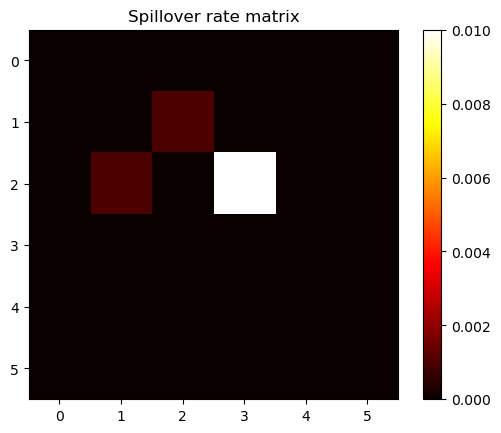

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.000  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.001  # γ_1->2
gamma_matrix[2, 1] = 0.001  # γ_2->1
gamma_matrix[2, 2] = 0.
gamma_matrix[2, 3] = 0.01  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.01* np.round(np.random.rand(num_qubits, num_qubits),3)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
# 
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
# Create the noisy backend tailored for spillover noise
backend = noisy_backend(qc, gamma_matrix, coupling_map=cm)
backend

AerSimulator('custom_spillover_impact_simulator'
             noise_model=<NoiseModel on ['rx(5.97, 1)', 'rx(4.60, 2)']>)

In [7]:
from qiskit.transpiler import PassManager, generate_preset_pass_manager
from qiskit.transpiler.passes import UnrollForLoops
pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
pm.translation.append(SpilloverNoiseAerPass(spillover_rate_matrix=numpy_to_hashable(gamma_matrix)))
pm.translation.append(UnrollForLoops())


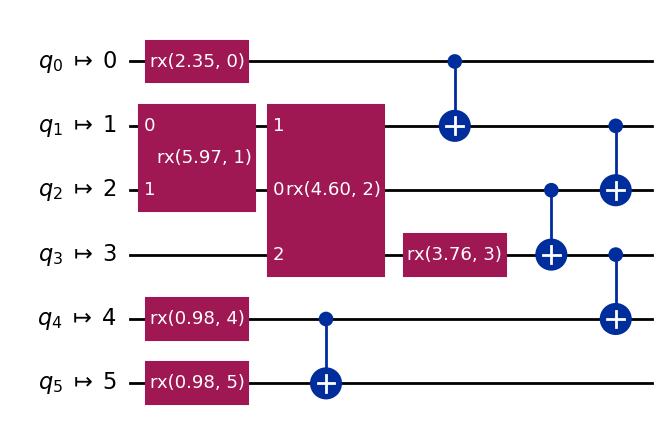

In [8]:
noisy_qc = pm.run(qc)
noisy_qc.draw("mpl")

In [9]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '04ea3978a48c4c3ab26eb1d6f5612841',
   'operations': ['rx(5.97, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99999554+0.j        , 0.        +0.j        ,
               0.        -0.00298675j, 0.        +0.j        ],
              [0.        +0.j        , 0.99999554+0.j        ,
               0.        +0.j        , 0.        -0.00298675j],
              [0.        -0.00298675j, 0.        +0.j        ,
               0.99999554+0.j        , 0.        +0.j        ],
              [0.        +0.j        , 0.        -0.00298675j,
               0.        +0.j        , 0.99999554+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1, 2)]},
  {'type': 'qerror',
   'id': 'e1fd1fbd1d514430876df1d799f501e4',
   'operations': ['rx(4.60, 2)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1, 2],
      'params': [array([[ 9.99732954e-01+0.j        ,  0.00000000e+00+0.j    

In [10]:
from qiskit import QuantumRegister
from rl_qoc.helpers import get_gate

# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]
    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])
    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [11]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc.environment import RescaleAndClipAction

action_space = Box(low=-1, high=1, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    pass_manager=pm,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=64,
        n_reps=[3, 6, 8, 9],
        n_shots=50,
        sampling_paulis=100,
    ),
    reward_config="channel",
)
q_env = ContextAwareQuantumEnvironment(q_env_config, circuit_context=qc)
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

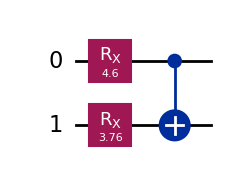

In [12]:
q_env.get_target(0, 1).causal_cone_circuit.draw("mpl")

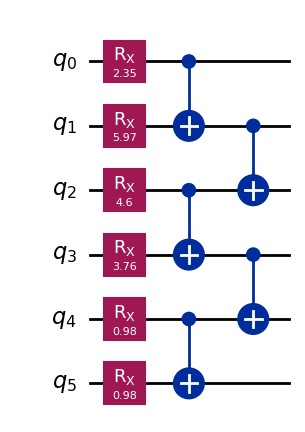

In [13]:
q_env.circuit_context.draw("mpl")

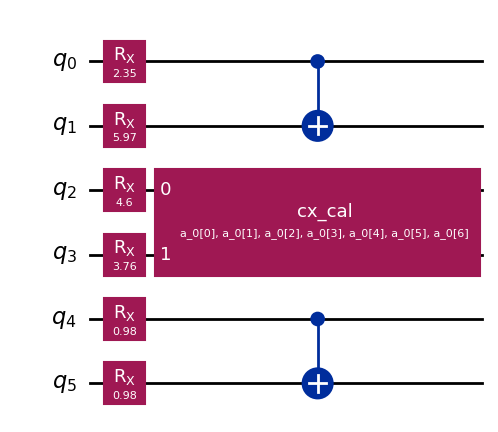

In [14]:
q_env.circuits[0].draw("mpl")

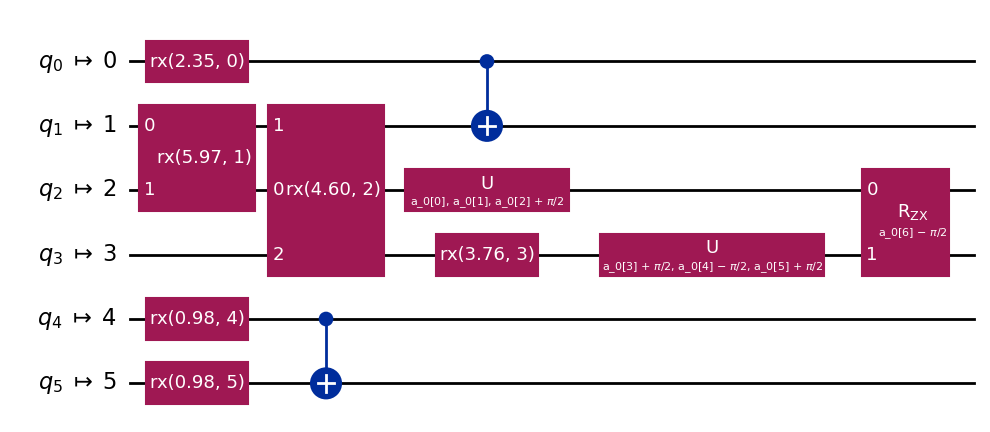

In [15]:
q_env.backend_info.custom_transpile(q_env.circuits[0]).draw("mpl")

In [16]:
from rl_qoc.agent import PPOConfig

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
agent_config = PPOConfig.from_yaml(file_name)
print(agent_config)

PPOConfig(run_name='spillover_subsystem', num_updates=1, n_epochs=8, learning_rate=0.0005, gamma=0.99, gae_lambda=0.95, clip_ratio=0.2, clip_value_loss=True, clip_value_coef=0.2, normalize_advantage=True, entropy_coef=0.01, value_loss_coef=0.5, gradient_clip=0.5, include_critic=True, hidden_layers=[64, 64], hidden_activation_functions=[Tanh(), Tanh()], input_activation_function=Identity(), output_activation_mean=Tanh(), output_activation_std=Sigmoid(), optimizer=<class 'torch.optim.adam.Adam'>, minibatch_size=16, checkpoint_dir='tmp/ppo', training_config=TrainingConfig(training_constraint=TotalUpdates(total_updates=250), target_fidelities=[0.999, 0.9999, 0.99999], lookback_window=10, anneal_learning_rate=False, std_actions_eps=0.01), train_function_settings=TrainFunctionSettings(plot_real_time=False, print_debug=False, num_prints=10, hpo_mode=False, clear_history=False, save_data=False), wandb_config=WandBConfig(enabled=True, project='GateCalibration', entity=None, tags=None, notes=Non

In [17]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env)
total_updates = 500
target_fidelities = [0.9]
lookback_window = 20
anneal_learning_rate = False

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

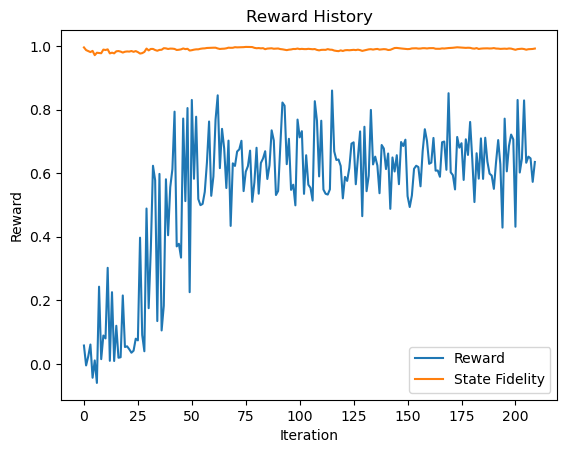


 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9931670353879333
Sending Estimator job...
Time for running 8.322916984558105
Finished Estimator job
Reward (avg): 0.6255013477740374 Std: 0.04054808810090246

 Number of repetitions: 6
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.994175591788497
Sending Estimator job...
Time for running 5.976881980895996
Finished Estimator job
Reward (avg): 0.7733551162713355 Std: 0.03815256626945104

 Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9938846010147895
Sending Estimator job...
Time for running 4.558966875076294
Finished Estimator job
Reward (avg): 0.6189592566763198 Std: 0.03804240217966864

 Number of repetitions: 6
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9941705978284714
Sending Estimator job...


{'avg_reward': [0.057584535244160316,
  -0.005134279784687584,
  0.023706465186197054,
  0.06071511407330278,
  -0.04382317910086568,
  0.010677542763897253,
  -0.06013216548213095,
  0.24277307145019317,
  0.014698221241096052,
  0.08911938819286223,
  0.07993578600017168,
  0.3021866244862423,
  0.00943858746973297,
  0.22546858060587138,
  0.008839242803158443,
  0.11979411139053413,
  0.0191081860640216,
  0.020694420816091498,
  0.21515894961404708,
  0.052816684491235735,
  0.05513493108958647,
  0.045883252548875014,
  0.034899143506272275,
  0.04126787350764385,
  0.07900763475297615,
  0.07377838644502699,
  0.3970256252855372,
  0.09091037918817786,
  0.03951325290561367,
  0.488801044972194,
  0.17506436343010906,
  0.362151641277377,
  0.6233896222359552,
  0.5777202404603436,
  0.13452779563209727,
  0.5978187162358626,
  0.10501578300759698,
  0.18257282100575378,
  0.5808620549669468,
  0.4046777010670646,
  0.5558597720303327,
  0.6129409026403454,
  0.793723340548435,


<Figure size 640x480 with 0 Axes>

In [18]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

In [28]:
q_env.observables

SparsePauliOp(['IIIIII', 'IIXIII', 'IIYIII', 'IIYIII', 'IIZIII', 'IIZIII', 'IIZIII', 'IIIXII', 'IIXXII', 'IIYXII', 'IIYXII', 'IIZXII', 'IIZXII', 'IIZXII', 'IIZXII', 'IIIYII', 'IIIYII', 'IIXYII', 'IIXYII', 'IIYYII', 'IIYYII', 'IIYYII', 'IIZYII', 'IIZYII', 'IIZYII', 'IIIZII', 'IIIZII', 'IIIZII', 'IIXZII', 'IIXZII', 'IIXZII', 'IIYZII', 'IIYZII', 'IIZZII', 'IIZZII'],
              coeffs=[ 0.25      +0.j,  0.25      +0.j, -0.51863532+0.j,  0.32927446+0.j,
 -0.32927446+0.j, -0.51863532+0.j, -0.67724969+0.j,  0.25      +0.j,
  0.25      +0.j,  0.32927446+0.j, -1.06672595+0.j,  1.06672595+0.j,
 -0.67724969+0.j, -0.32927446+0.j, -0.51863532+0.j,  0.38854814+0.j,
  0.457407  +0.j, -0.72045498+0.j,  0.457407  +0.j, -0.75018957+0.j,
 -0.42937644+0.j,  0.36473736+0.j, -0.36473736+0.j,  0.88313884+0.j,
 -0.42937644+0.j, -0.457407  +0.j,  0.38854814+0.j,  0.61199642+0.j,
  0.38854814+0.j, -0.72045498+0.j,  0.457407  +0.j, -0.36473736+0.j,
 -0.42937644+0.j,  0.42937644+0.j, -0.36473736+0.j])

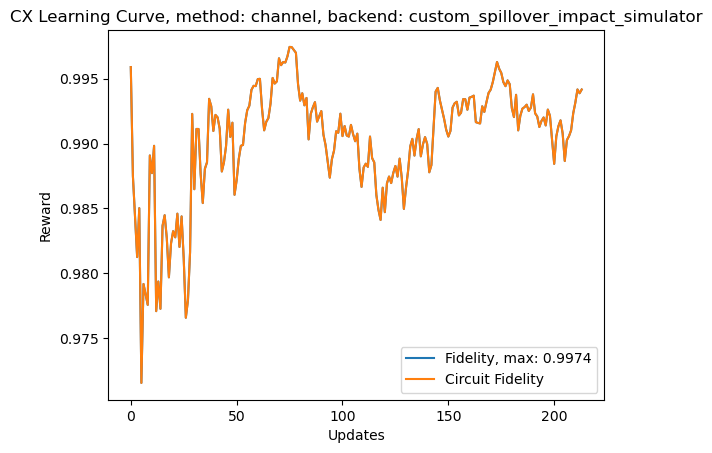

In [20]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

# plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
# plt.plot(
#     q_env.circuit_fidelity_history_nreps,
#     label=f"Circuit Fidelity nreps(={q_env.n_reps})",
# )
# plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

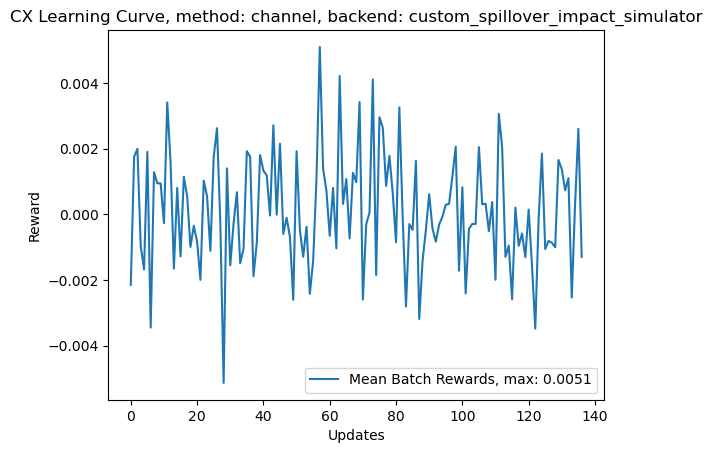

In [20]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
# plt.plot(
#     q_env.fidelity_history,
#     label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
# )
# plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
# plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
# plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [33]:
q_env.optimal_action

array([ 0.16718724, -0.1882672 , -0.16773811, -0.2       ,  0.02085974,
       -0.14108044,  0.2       ], dtype=float32)

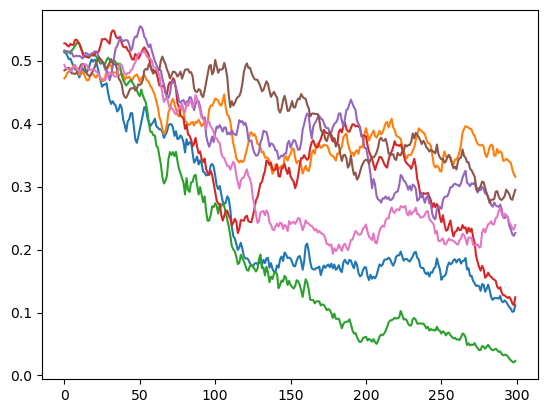

In [35]:
plt.plot(ppo_agent.training_results["std_action"])

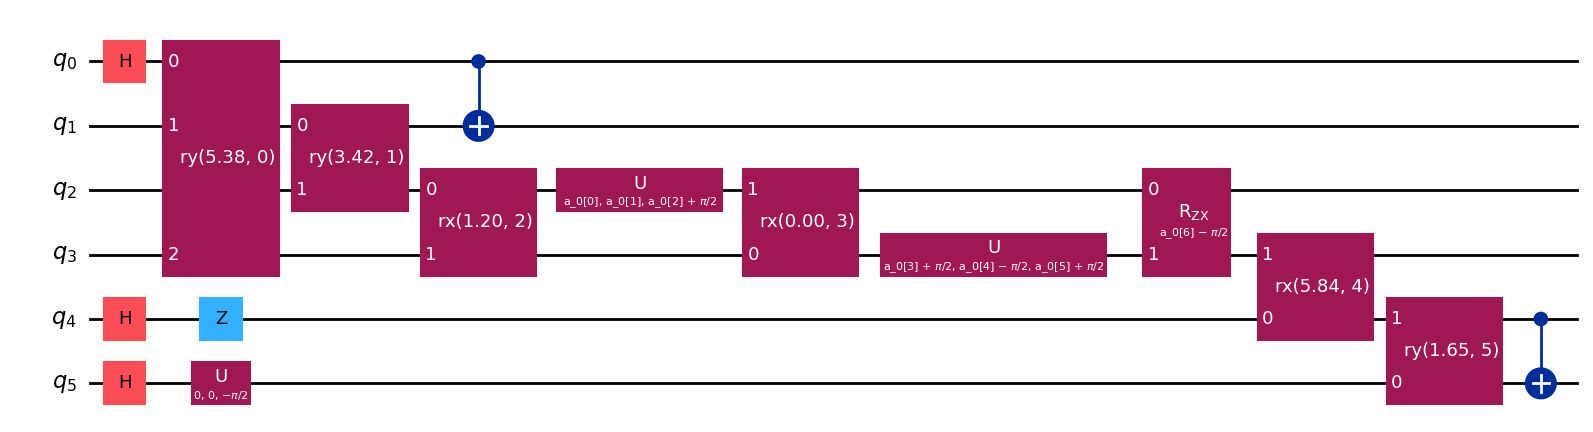

In [37]:
q_env._pubs[0][0].draw("mpl")

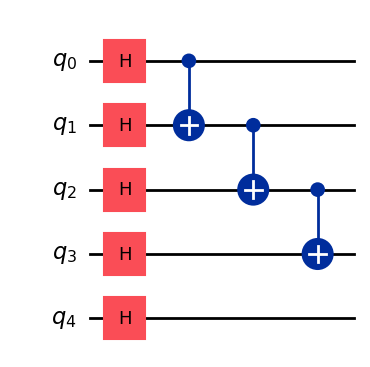

In [2]:
from qiskit.circuit import QuantumCircuit
from rl_qoc.helpers.transpiler_passes import CustomGateReplacementPass
from qiskit.transpiler import PassManager
qc = QuantumCircuit(5)
qc.h(range(5))
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.draw("mpl")

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_90893/1674038932.py:7: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  dag_to_circuit(pass_.run(circuit_to_dag(qc))).draw("mpl")
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_90893/1674038932.py:7: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.unit`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  dag_to_circuit(pass_.run(circuit_to_dag(qc))).draw("mpl")


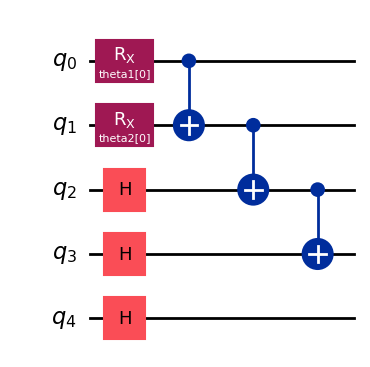

In [6]:
from qiskit.circuit import ParameterVector
from qiskit.converters import circuit_to_dag, dag_to_circuit
def custom_gate(qc, params, qregs):
    qc.rx(params[0], qregs[0])
pass_ = CustomGateReplacementPass([('h', (0,)), ('h', (1,))], [custom_gate, custom_gate], [ParameterVector("theta1", 1), ParameterVector("theta2", 1)])
pm = PassManager([pass_])
dag_to_circuit(pass_.run(circuit_to_dag(qc))).draw("mpl")